In [234]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.io import wavfile
from scipy.signal import spectrogram
from scipy.signal import resample
from librosa.display import specshow
import os
import benchmark
import utils
import pandas as pd

In [235]:
#getting all the saxophone wav audios files in an list : audio_files
type_wanted = "bassoon.wav"
directory = r"C:\Users\hippo\OneDrive\Bureau\MINES\2A\T2_Data_Sophia\PROJET\Bach10_v1.1"
audio_filespath =[]
audio_files_tuple = []
for root, dirs, files in os.walk(directory):
    for filename in files:
        #print(os.path.join(root, filename))
        if filename[len(filename)-len(type_wanted):len(filename)] == type_wanted :
            pathfile = os.path.join(root, filename)
            audio_filespath.append(pathfile)
            audio_files_tuple.append(wavfile.read(pathfile))

In [236]:
sample_rate = audio_files_tuple[0][0]
print(sample_rate)
new_sample_rate = 32000


44100


In [237]:
audio_files = []
list_audio = []
for i in range(len(audio_files_tuple)):
    audio_files.append([audio_files_tuple[i][0], audio_files_tuple[i][1].astype(dtype = np.float64)])
    list_audio.append(resample(audio_files[i][1], int(len(audio_files[i][1])*new_sample_rate/audio_files[i][0]), window= "hamming", domain = "time"))

audio_1 = audio_files[0][1]


In [238]:
#Resampling du signal : 
audio_1 = resample(audio_1, int(len(audio_1)*new_sample_rate/sample_rate), window= "hamming", domain = "time")
audio_1 = audio_1

In [239]:
temps_paquet = 0.02#0 #20ms
taille_paquet = int(temps_paquet *new_sample_rate) #nb_echantillons par paquet
print(taille_paquet)
num_paquet_choisi = 100
pos_sample = num_paquet_choisi*taille_paquet
paquet = audio_1[pos_sample:pos_sample + taille_paquet].copy()
np.dtype(paquet[0])

640


dtype('float64')

In [240]:
pos_loss = utils.los_generation(len(audio_1), taille_paquet, 100)
print(len(pos_loss), pos_loss)

91 [ 18550  28927  32997  50296  52446  72923  79191  83704  86989 113954
 116147 121447 132172 134284 135993 144627 148520 169164 174812 177004
 178454 202081 205524 226429 228509 237630 240215 244044 245088 248267
 250490 255037 260289 269342 274072 277213 289672 292397 306420 334241
 337456 340156 343679 345769 348275 360343 363017 364719 374558 379600
 394365 396067 403345 413820 421367 437556 441248 452618 453693 455118
 498089 510975 533151 556078 566490 572524 573868 581005 592682 631170
 633678 639202 640829 646352 660695 666654 672133 680187 682177 722207
 723105 729778 731971 732778 736199 739371 740839 753475 759860 785923
 788494]


In [269]:
#préparation des datas : 
def data_prep(list_audio_files, n_audio, taille_paquet, instr = 'Saxphone', prop_train_test = 0.8):
    n_files = len(list_audio_files)
    n_train = int(n_files*prop_train_test)-1
    dir_path = f"Dataset_{instr}"
    #dir_path = os.path.join(os.path.dirname(os.path.realpath(__file__)),dirname)
    list_paths = []
    os.mkdir(dir_path)
    for i in range(n_files) : 
        song = list_audio_files[i]
        pos_gap = utils.los_generation(len(song), taille_paquet, 110)
        for j in range(len(pos_gap)):
            if i <= n_train :
                audio = song[pos_gap[j]- n_audio: pos_gap[j]]
                label = song[pos_gap[j]: pos_gap[j] + taille_paquet]
                #label = np.pad(label, (0, taille_paquet))
                name = f"Train_paquet{i}_{j}.wav"
                name_label = f"Train_label{i}_{j}.wav"
                
                #dir_path = os.path.dirname(os.path.realpath(__file__))
            if i > n_train : 
                audio = song[pos_gap[j]- n_audio: pos_gap[j]]
                label = song[pos_gap[j]: pos_gap[j] + taille_paquet]
                #label = np.pad(label, (0, taille_paquet))
                name = f"Test_paquet{i}_{j}.wav"
                name_label = f"Test_label{i}_{j}.wav"
                name_label = f"Test_paquet{i}_{j}.wav"
            path = os.path.join(dir_path,name)
            path_label = os.path.join(dir_path,name_label)
            list_paths.append([name, name_label])
            wavfile.write(path, new_sample_rate, audio)
            wavfile.write(path_label, new_sample_rate, label)
        df = pd.DataFrame(list_paths, columns = ["previous_audio", "label"])
        name = 'Dataframe.csv'
        data_path = os.path.join(dir_path, name)
        df.to_csv(data_path)



In [270]:
data_prep(list_audio, 2*taille_paquet, taille_paquet)

In [271]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision


In [280]:
class Audio_Loss(Dataset):
    """Audio loss packet."""
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the audios.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.paths = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        audio_path = os.path.join(self.root_dir, self.paths.iloc[idx]['previous_audio'])
        label_path = os.path.join(self.root_dir, self.paths.iloc[idx]['label'])
        audio = np.array(wavfile.read(audio_path)[1], dtype = np.float64)
        label = np.array(wavfile.read(label_path)[1], dtype = np.float64)
        label = np.pad(label, (0, taille_paquet), mode = 'constant')
        sample = {'previous_audio': audio, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [281]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        previous_audio, label = sample['previous_audio'], sample['label']

        return {'previous_audio': torch.from_numpy(previous_audio),
                'label': torch.from_numpy(label)}

In [282]:
audio_dataset = Audio_Loss(r"C:\Users\hippo\OneDrive\Bureau\MINES\2A\T2_Data_Sophia\PROJET\Data-Sophia-\Dataset_Saxphone\Dataframe.csv", 
                           r"C:\Users\hippo\OneDrive\Bureau\MINES\2A\T2_Data_Sophia\PROJET\Data-Sophia-\Dataset_Saxphone",
                           transform=ToTensor())

In [283]:
def plot_audio(previous_audio, label) : 
    
    t_1 = np.linspace(0,2*temps_paquet,len(previous_audio))
    t_2 = np.linspace(2*temps_paquet,4*temps_paquet,len(label))
    plt.plot(t_1, previous_audio, 'b--')
    plt.plot(t_2, label, 'r--')
    plt.pause(0.001)

0 torch.Size([1280]) torch.Size([1280])
1 torch.Size([1280]) torch.Size([1280])
2 torch.Size([1280]) torch.Size([1280])
3 torch.Size([1280]) torch.Size([1280])


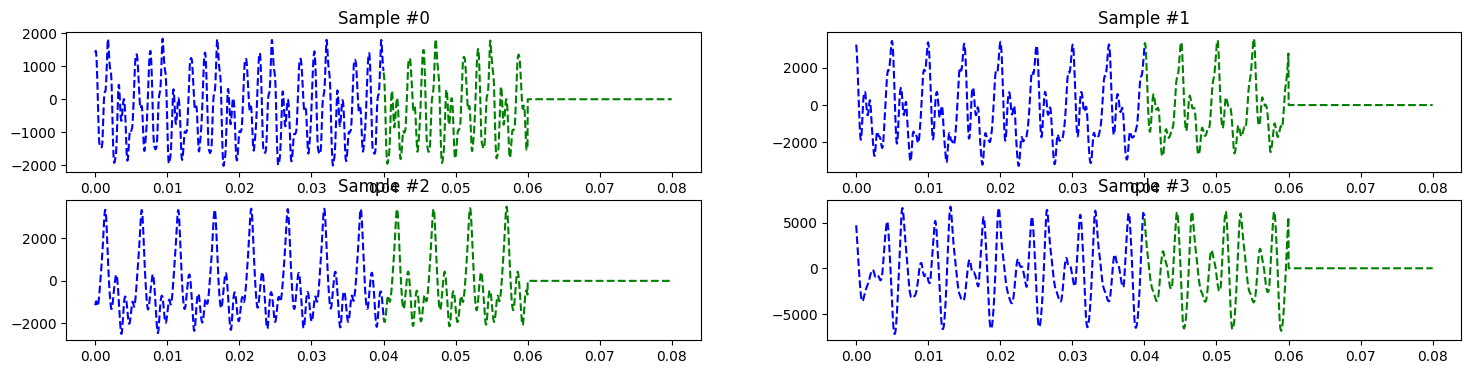

In [284]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(18,4))
ax = axes.flatten()
for i, sample in enumerate(audio_dataset):
    print(i, sample['previous_audio'].shape, sample['label'].shape)

    #plt.tight_layout()
    ax[i].set_title('Sample #{}'.format(i))
    #ax.axis('off')
    previous_audio, label = sample['previous_audio'], sample['label']
    t_1 = np.linspace(0,2*temps_paquet,len(previous_audio))
    t_2 = np.linspace(2*temps_paquet,4*temps_paquet,len(label))
    ax[i].plot(t_1, previous_audio, 'b--')
    ax[i].plot(t_2, label, 'g--')

    if i == 3:
        plt.show()
        break

In [290]:
# problème : dans un même batch les audios sont liés
dataloader = DataLoader(audio_dataset, batch_size=6,
                        shuffle=False, num_workers=0)

In [291]:
def batch_audio_plot(sample_batched) : 
    previous_audio_batched, label_batched = sample_batched['previous_audio'], sample_batched['label']
    batch_size = len(previous_audio_batched)
    #im_size = images_batch.size(2)

    #plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        t_1 = np.linspace(0, 2*temps_paquet, len(previous_audio_batched[i]))
        t_2 = np.linspace(2*temps_paquet, 4*temps_paquet, len(label_batched[i]))
        plt.subplot(1,batch_size, i+1)
        plt.plot(t_1, previous_audio_batched[i])
        plt.subplot(1, batch_size, i+1)
        plt.plot(t_2, label_batched[i])
        plt.title('Batch from dataloader')

0 torch.Size([6, 1280]) torch.Size([6, 1280])
1 torch.Size([6, 1280]) torch.Size([6, 1280])
2 torch.Size([6, 1280]) torch.Size([6, 1280])
3 torch.Size([6, 1280]) torch.Size([6, 1280])
4 torch.Size([6, 1280]) torch.Size([6, 1280])
5 torch.Size([6, 1280]) torch.Size([6, 1280])
6 torch.Size([6, 1280]) torch.Size([6, 1280])
7 torch.Size([6, 1280]) torch.Size([6, 1280])
8 torch.Size([6, 1280]) torch.Size([6, 1280])
9 torch.Size([6, 1280]) torch.Size([6, 1280])
10 torch.Size([6, 1280]) torch.Size([6, 1280])


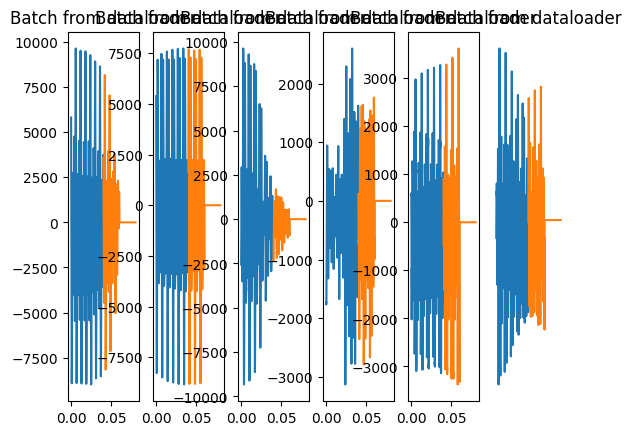

In [297]:
if __name__ == '__main__':
    for i_batch, sample_batched in enumerate(dataloader):
        print(i_batch, sample_batched['previous_audio'].size(),
            sample_batched['label'].size())
        # observe 4th batch and stop.
        if i_batch == 10:
            plt.figure()
            batch_audio_plot(sample_batched)
            plt.axis('off')
            plt.ioff()
            plt.show()
            break

In [298]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [303]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2*taille_paquet, 1024),
            nn.ReLU(),
            nn.Linear(1024, 640),
            nn.ReLU(),
            nn.Linear(640, taille_paquet),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [306]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1280, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=640, bias=True)
    (3): ReLU()
    (4): Linear(in_features=640, out_features=640, bias=True)
  )
)


In [309]:
train = model(dataloader)


AttributeError: 'DataLoader' object has no attribute 'flatten'